<a href="https://colab.research.google.com/github/CallmeQuant/Studying-Notebook/blob/main/Supply%20Chain/VRP/notebooks/VRP_RL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive, files
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Libraries**

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import argparse
import datetime
import time
# Torch
import torch
from torch.utils.data import Dataset, DataLoader

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from functools import partial

# **Ultis and Dataset**

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class Timer:
  """
  Record multiple running times.
  """
  def __init__(self):
    """
    Defined in :numref:`sec_minibatch_sgd`
    """
    self.times = []
    self.start()

  def start(self):
    """
    Start the timer.
    """
    self.tik = time.time()

  def stop(self):
    """
    Stop the timer and record the time in a list.
    """
    self.times.append(time.time() - self.tik)
    return self.times[-1]

  def avg(self):
    """
    Return the average time.
    """
    return sum(self.times) / len(self.times)

  def sum(self):
    """
    Return the sum of time.
    """
    return sum(self.times)

  def cumsum(self):
    """
    Return the accumulated time.
    """
    return np.array(self.times).cumsum().tolist()

def fix_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

class VRPDataset(Dataset):
    """
    Dataset class for Vehicle Routing Problem
    """
    def __init__(self, num_samples, input_size, max_load = 20, max_demand = 9, seed = None):
        super(VRPDataset, self).__init__()

        if max_load < max_demand:
            raise ValueError('Maximum demand of customers can not exceed the maximum load of vehicles')

        if seed is None:
            seed = np.random.randint(1234567890)

        fix_seed(seed)

        self.num_samples = num_samples
        self.max_load = max_load
        self.max_demand = max_demand

        # Including the location of depot, which is 0
        # shape: num_samples x (x-coord, y-coord), num_customers + 1)
        locations_coord = torch.rand((num_samples, 2, input_size + 1))
        self.static_feats = locations_coord

        # Dynamic feats
        # trucks' loads
        # To avoid passing large values to neural network => scale values to [0,1]
        dynamic_shape = (num_samples, 1, input_size + 1)
        loads = torch.full(dynamic_shape, 1.)

        # customers' demands
        # Same as loads, to avoid large number => scale values by maximum loads
        demands = torch.randint(1, max_demand + 1, dynamic_shape)
        demands = demands / float(max_load)

        # Set demands at depot to 0
        demands[:, 0, 0] = 0
        self.dynamic_feats = torch.tensor(np.concatenate((loads, demands), axis = 1))

    def __len__(self):
        return self.num_samples

    def __getitem__(self, index):
        # (static_feats, dynamic_feats, start_location)
        return (self.static_feats[index], self.dynamic_feats[index], self.static_feats[index, :, 0:1])

    def _update_mask(self, mask, dynamic_feats, chosen_index = None):
        """
        Updates the mask to hide non-valid states

        Parameters
        ----------
        dynamic: torch.autograd.Variable (num_samples, num_feats, seq_len)
        """

        loads = dynamic_feats.data[:, 0] # (batch_size, seq_len)
        demands = dynamic_feats.data[:, 1]  # (batch_size, seq_len)

        # Masking procedures
        # Customers with zero demands can not be visited => If no positive demand, end tour
        if demands.eq(0).all():
            return demands * 0

        # feasible states of mask: customers with positive demands larger than loads will be masked
        updated_mask = demands.ne(0) * demands.lt(loads)

        # Avoiding going to depot back and forth
        return_home = chosen_index.ne(0)

        # If vehicle just visited depot, allow to visit again. Otherwise, not allowed
        if return_home.any():
            updated_mask[return_home.nonzero(), 0] = 1.

        if (~return_home).any():
            updated_mask[(~return_home).nonzero(), 0] = 0.

        no_load_remain = loads[:, 0].eq(0).float()
        no_demands_remain = demands[:, 1:].sum(1).eq(0).float()

        merged = (no_load_remain + no_demands_remain).gt(0)

        if merged.any():
            updated_mask[merged.nonzero(), 0] = 1.
            updated_mask[merged.nonzero(), 1:] = 0.

        return updated_mask.float()

    def _update_dynamic_feats(self, dynamic_feats, chosen_index):
        """
        Updates the loads and demands dataset
        """
        # Update the dynamic elements differently for if we visit depot vs. a city
        visit = chosen_index.ne(0)
        depot = chosen_index.eq(0)

        # Clone dynamic feats
        all_loads = dynamic_feats[:, 0].clone()
        all_demands = dynamic_feats[:, 1].clone()

        # Extract load and demand corresponding to vehicle/customer
        load = torch.gather(all_loads, 1, chosen_index.unsqueeze(1))
        demand = torch.gather(all_demands, 1, chosen_index.unsqueeze(1))

        # Along all minibatch, if we choose a customer, we will satisfy demands as much as possible
        if visit.any():
            new_load = torch.clamp(load - demand, min = 0)
            new_demand = torch.clamp(demand - load, min = 0)

            # Squeeze to be a number
            visit_index = visit.nonzero().squeeze()

            all_loads[visit_index] = new_load[visit_index]
            all_demands[visit_index, chosen_index[visit_index]] = new_demand[visit_index].view(-1)
            # Check how much demand/capacity is used up at depot when vehicles take on new load
            all_demands[visit_index, 0] = -1. + new_load[visit_index].view(-1)

        # Back to depot to refill
        if depot.any():
            all_loads[depot.nonzero().squeeze()] = 1.
            all_demands[depot.nonzero().squeeze(), 0] = 0.

        updated_dynamic_feats = torch.cat((all_loads.unsqueeze(1), all_demands.unsqueeze(1)), 1)
        return torch.tensor(updated_dynamic_feats.data, device = dynamic_feats.device)

def reward(static_feats, tour_indices):
    """
    Given tour indices, compute the Euclidean distance between all customers' locations (cities)
    """

    # # Convert the indices back into a tour
    index = tour_indices.unsqueeze(1).expand(-1, static_feats.size(1), -1)
    tour = torch.gather(static_feats.data, 2, index).permute(0, 2, 1)

    # Add the depot location
    start = static_feats.data[:, :, 0].unsqueeze(1)
    y = torch.cat((start, tour, start), dim = 1)

    # Euclidean distance between two consecutive points
    tour_len = torch.sqrt(torch.sum(torch.pow(y[:, :-1] - y[:, 1:], 2), dim=2))

    return tour_len.sum(1)

def plot_solution(static, tour_indices, save_path):
    """Plots the found solution."""

    plt.close('all')

    num_plots = 3 if int(np.sqrt(len(tour_indices))) >= 3 else 1

    _, axes = plt.subplots(nrows=num_plots, ncols=num_plots,
                           sharex='col', sharey='row')

    if num_plots == 1:
        axes = [[axes]]
    axes = [a for ax in axes for a in ax]

    for i, ax in enumerate(axes):

        # Convert the indices back into a tour
        idx = tour_indices[i]
        if len(idx.size()) == 1:
            idx = idx.unsqueeze(0)

        idx = idx.expand(static.size(1), -1)
        data = torch.gather(static[i].data, 1, idx).cpu().numpy()

        start = static[i, :, 0].cpu().data.numpy()
        x = np.hstack((start[0], data[0], start[0]))
        y = np.hstack((start[1], data[1], start[1]))

        # Assign each subtour a different colour & label in order traveled
        idx = np.hstack((0, tour_indices[i].cpu().numpy().flatten(), 0))
        where = np.where(idx == 0)[0]

        for j in range(len(where) - 1):

            low = where[j]
            high = where[j + 1]

            if low + 1 == high:
                continue

            ax.plot(x[low: high + 1], y[low: high + 1], zorder=1, label=j)

        ax.legend(loc="upper right", fontsize=3, framealpha=0.5)
        ax.scatter(x, y, s=4, c='r', zorder=2)
        ax.scatter(x[0], y[0], s=20, c='k', marker='*', zorder=3)

        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)

    plt.tight_layout()
    plt.savefig(save_path, bbox_inches='tight', dpi=200)

## **Example**

In [4]:
# # Example - Reward function
# static_feats = torch.tensor([
#     [[0, 1, 2], [0, 1, 2]],  # Sample 1: coordinates of depot, city1, city2
#     [[0, -1, -2], [0, -1, -2]]  # Sample 2: coordinates of depot, city1, city2
# ])

# tour_indices = torch.tensor([
#     [0, 1, 2],  # Tour for sample 1
#     [0, 2, 1]   # Tour for sample 2
# ])

# idx = tour_indices.unsqueeze(1).expand(-1, static_feats.size(1), -1)
# tour = torch.gather(static_feats.data, 2, idx).permute(0, 2, 1)
# start = static_feats.data[:, :, 0].unsqueeze(1)
# y = torch.cat((start, tour, start), dim=1)
# tour_len = torch.sqrt(torch.sum(torch.pow(y[:, :-1] - y[:, 1:], 2), dim=2))
# tour_len = tour_len.sum(1)
# print(idx)
# print(tour)
# print(tour_len)

# # Define a VRPDataset object
# vrp_dataset = VRPDataset(num_samples=1, input_size=5)

# # Get a sample from the dataset
# static_feats, dynamic_feats, start_location = vrp_dataset[0]

# # Print static features (locations)
# print("Static features:")
# print(static_feats)

# # Print dynamic features (loads and demands)
# print("Dynamic features:")
# print(dynamic_feats)

# Initialize a mask with all ones
# mask = torch.ones((1, 6))

# # Print initial mask
# print("Initial mask:")
# print(mask)

# # Choose a customer index (for example, 3)
# chosen_index = torch.tensor([3])

# # Update mask using update_mask method
# mask = vrp_dataset._update_mask(mask, dynamic_feats.unsqueeze(0), chosen_index)

# # Print updated mask
# print("Updated mask:")
# print(mask)

# **Modules**

In [5]:
class Embedding(nn.Module):
    """
    Encodes the static and dynamic features (states) using 1D covolutional layers
    Note that the operation of Conv1D is the same as nn.Linear if we think set out_features
    equal to the out_channels (i.e., embedding_size).
    """
    def __init__(self, input_size, embedding_size):
        super(Embedding, self).__init__()
        self.conv = nn.Conv1d(input_size, embedding_size, kernel_size=1)

    def forward(self, input):
        output = self.conv(input)
        return output # shape (batch_size, embedding_size/hidden_size, seq_len)

class Attention_layer(nn.Module):
    """
    Compute the additive attention over the input nodes given the current states (hidden states)
    """

    def __init__(self, hidden_size):
        super(Attention_layer, self).__init__()

        # W processes features from static decoder elements
        self.v = nn.Parameter(torch.zeros((1, 1, hidden_size),
                                          device=device, requires_grad=True))

        self.W = nn.Parameter(torch.zeros((1, hidden_size, 3 * hidden_size),
                                          device=device, requires_grad=True))

    def forward(self, static_feats_hidden, dynamic_feats_hidden, decoder_hidden):
        batch_size, hidden_size, _ = static_feats_hidden.size()

        hidden = decoder_hidden.unsqueeze(2).expand_as(static_feats_hidden)
        hidden = torch.cat((static_feats_hidden, dynamic_feats_hidden, hidden), 1)

        # Broadcast first dimensions to match batch_size, so we can do batch-matrix-multiply
        v = self.v.expand(batch_size, 1, hidden_size)
        W = self.W.expand(batch_size, hidden_size, -1)

        attentions = torch.bmm(v, torch.tanh(torch.bmm(W, hidden))) # (W @ hidden) -> (batch_size, hidden_size, seq_len) -> v -> (batch_size, 1, seq_len)
        attentions = F.softmax(attentions, dim=2)  # (batch, 1, seq_len)
        if attentions.ndimension() < 3: # Make sure the shape to be (batch_size, 1, seq_len)
            attentions = attentions.unsqueeze(1)
        return attentions

class Pointer(nn.Module):
    """
    Compute the next state given the previous state and input embeddings.
    """

    def __init__(self, hidden_size, num_layers=1, dropout=0.2):
        super(Pointer, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Used to calculate probability of selecting next state
        self.v = nn.Parameter(torch.zeros((1, 1, hidden_size),
                                          device=device, requires_grad=True))

        self.W = nn.Parameter(torch.zeros((1, hidden_size, 2 * hidden_size),
                                          device=device, requires_grad=True))

        # Used to compute a representation of the current decoder output
        self.gru = nn.GRU(hidden_size, hidden_size, num_layers,
                          batch_first=True,
                          dropout=dropout if num_layers > 1 else 0)
        self.encoder_attn = Attention_layer(hidden_size)

        self.drop_rnn = nn.Dropout(p=dropout)
        self.drop_hh = nn.Dropout(p=dropout)

    def forward(self, static_hidden, dynamic_hidden, decoder_hidden, last_hh):
        """
        Parameters
        ----------
        static_hidden: torch tensor of shape (batch_size, hidden_size, seq_len)
            Embedded static features
        dynamic_hidden: torch tensor of shape (batch_size, hidden_size, seq_len)
            Embedded dynamic features
        decoder_hidden: torch tensor of shape (batch_size, hidden_size, seq_len)
            current state of decoder
        last_hh: tensor of shape (num_layers, batch_size, hidden_size)
            last hidden state of RNN (here is GRU)
        """

        # input for RNN in torch must have shape (batch_size, seq_len, hidden_size) for batched input
        rnn_out, last_hh = self.gru(decoder_hidden.transpose(2, 1), last_hh) # rnn_output: (batch_size, 1, hidden_size)
        rnn_out = rnn_out.squeeze(1) # (batch_size, hidden_size)
        # # output of decoder shape
        # print(rnn_out.shape)

        # Always apply dropout on the RNN output
        rnn_out = self.drop_rnn(rnn_out)
        if self.num_layers == 1:
            # If > 1 layer dropout is already applied
            last_hh = self.drop_hh(last_hh)

        # Given a summary of the output, find an  input context
        enc_attn = self.encoder_attn(static_hidden, dynamic_hidden, rnn_out) # (batch_size, seq_len)

        context = enc_attn.bmm(static_hidden.permute(0, 2, 1))  # (batch_size, 1, hidden_size/num_feats)

        # Calculate the next output using Batch-matrix-multiply ops
        context = context.transpose(1, 2).expand_as(static_hidden)
        energy = torch.cat((static_hidden, context), dim=1)  # (batch_size, 2*num_feats, seq_len)

        v = self.v.expand(static_hidden.size(0), -1, -1)
        W = self.W.expand(static_hidden.size(0), -1, -1)

        # Get (batch_size, 1, seq_len) then squeezed
        # Unnormalized probabilities of pointing to each element in input
        probs = torch.bmm(v, torch.tanh(torch.bmm(W, energy))).squeeze(1)

        return probs, last_hh # probs shape (batch_size, seq_len), last_hh shape (num_layers, batch_size, hidden_size)


# **Models**

## **Critic**

In [6]:
class StateCritic(nn.Module):
    """Estimates the problem complexity.

    This is a basic module that just looks at the log-probabilities predicted by
    the encoder + decoder, and returns an estimate of complexity
    """

    def __init__(self, static_size, dynamic_size, hidden_size):
        super(StateCritic, self).__init__()

        self.static_encoder = Embedding(static_size, hidden_size)
        self.dynamic_encoder = Embedding(dynamic_size, hidden_size)

        # Define the encoder & decoder models
        self.fc1 = nn.Conv1d(hidden_size * 2, 20, kernel_size=1)
        self.fc2 = nn.Conv1d(20, 20, kernel_size=1)
        self.fc3 = nn.Conv1d(20, 1, kernel_size=1)

        for p in self.parameters():
            if len(p.shape) > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, static, dynamic):

        # Use the probabilities of visiting each
        static_hidden = self.static_encoder(static)
        dynamic_hidden = self.dynamic_encoder(dynamic)

        hidden = torch.cat((static_hidden, dynamic_hidden), 1)

        output = F.relu(self.fc1(hidden))
        output = F.relu(self.fc2(output))
        output = self.fc3(output).sum(dim=2)
        return output


class Critic(nn.Module):
    """Estimates the problem complexity.

    This is a basic module that just looks at the log-probabilities predicted by
    the encoder + decoder, and returns an estimate of complexity
    """

    def __init__(self, hidden_size):
        super(Critic, self).__init__()

        # Define the encoder & decoder models
        self.fc1 = nn.Conv1d(1, hidden_size, kernel_size=1)
        self.fc2 = nn.Conv1d(hidden_size, 20, kernel_size=1)
        self.fc3 = nn.Conv1d(20, 1, kernel_size=1)

        for p in self.parameters():
            if len(p.shape) > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, input):

        output = F.relu(self.fc1(input.unsqueeze(1)))
        output = F.relu(self.fc2(output)).squeeze(2)
        output = self.fc3(output).sum(dim=2)
        return output

## **Actor**

In [7]:
class TSP_RL(nn.Module):
    """Defines the main Encoder, Decoder, and Pointer combinatorial models.

    Parameters
    ----------
    static_size: int
        Defines how many features are in the static elements of the model
        (e.g. 2 for (x, y) coordinates)
    dynamic_size: int > 1
        Defines how many features are in the dynamic elements of the model
        (e.g. 2 for the VRP which has (load, demand) attributes. The TSP doesn't
        have dynamic elements, but to ensure compatibility with other optimization
        problems, assume we just pass in a vector of zeros.
    hidden_size: int
        Defines the number of units in the hidden layer for all static, dynamic,
        and decoder output units.
    update_fn: callable or None
        If provided, this method is used to calculate how the input dynamic
        elements are updated, and is called after each 'point' to the input element.
        For example, for the VRP, this function can reduce the load and demand of
        the visited node by one unit.
    mask_fn: callable or None
        Allows us to specify which elements of the input sequence are allowed to
        be selected. This is useful for speeding up training of the networks,
        by providing a sort of 'rules' guidelines to the algorithm. If no mask
        is provided, we terminate the search after a fixed number of iterations
        to avoid tours that stretch forever.
        For example, for the VRP, this function can prevent pointing to nodes that
        have zero demand or exceed the vehicle capacity.
    num_layers: int
        Specifies the number of hidden layers to use in the decoder RNN
    dropout: float
        Defines the dropout rate for the decoder
    """

    def __init__(self, static_size, dynamic_size, hidden_size,
                 update_fn=None, mask_fn=None, num_layers=1, dropout=0.):
        super(TSP_RL, self).__init__()

        if dynamic_size < 1:
            raise ValueError(':param dynamic_size: must be > 0, even if the '
                             'problem has no dynamic elements')

        self.update_fn = update_fn
        self.mask_fn = mask_fn

        # Define the encoder & decoder models
        self.static_encoder = Embedding(static_size, hidden_size)  # (batch_size, hidden_size)
        self.dynamic_encoder = Embedding(dynamic_size, hidden_size) # (batch_size, hidden_size)
        self.decoder = Embedding(static_size, hidden_size) # (batch_size, hidden_size)
        self.pointer = Pointer(hidden_size, num_layers, dropout) # (batch_size, hidden_size) & (num_layers, batch_size, hidden_size)

        for p in self.parameters():
            if len(p.shape) > 1:
                nn.init.xavier_uniform_(p)

        # Used as a proxy initial state in the decoder when not specified
        self.x0 = torch.zeros((1, static_size, 1), requires_grad=True, device=device)

    def forward(self, static, dynamic, decoder_input=None, last_hh=None):
        """
        Parameters
        ----------
        static: Array of size (batch_size, num_feats, num_customers)
            Defines the elements to consider as static. For the TSP, this could be
            things like the (x, y) coordinates, which won't change
        dynamic: Array of size (batch_size, num_feats, num_customers)
            Defines the elements to consider as static. For the VRP, this can be
            things like the (load, demand) of each city. If there are no dynamic
            elements, this can be set to None
        decoder_input: Array of size (batch_size, static_size)
            Defines the outputs for the decoder. Currently, we just use the
            static elements (e.g. (x, y) coordinates), but this can technically
            be other things as well
        last_hh: Array of size (num_layers, batch_size, num_hidden)
            Defines the last hidden state for the RNN
        """

        batch_size, input_size, sequence_size = static.size()

        if decoder_input is None:
            decoder_input = self.x0.expand(batch_size, -1, -1)

        # Always use a mask - if no function is provided, we don't update it
        mask = torch.ones(batch_size, sequence_size, device=device)

        # Structures for holding the output sequences
        tour_idx, tour_logprob = [], []
        max_steps = sequence_size if self.mask_fn is None else 1000

        # Static elements only need to be processed once, and can be used across
        # all 'pointing' iterations. When / if the dynamic elements change,
        # their representations will need to get calculated again.
        static_hidden = self.static_encoder(static)
        dynamic_hidden = self.dynamic_encoder(dynamic)

        for _ in range(max_steps):
            # Checking if all values in mask is zero
            if not mask.byte().any():
                break

            # ... but compute a hidden rep for each element added to sequence
            decoder_hidden = self.decoder(decoder_input)

            probs, last_hh = self.pointer(static_hidden,
                                          dynamic_hidden,
                                          decoder_hidden, last_hh)
            probs = F.softmax(probs + mask.log(), dim=1)

            # When training, sample the next step according to its probability.
            # During testing, we can take the greedy approach and choose highest
            if self.training:
                m = torch.distributions.Categorical(probs)

                ptr = m.sample() # (batch_size,)
                # Check with the mask if the customer is valid or not. If not valid, sample again till valid customer/city
                while not torch.gather(mask, 1, ptr.data.unsqueeze(1)).byte().all():
                    ptr = m.sample()
                logp = m.log_prob(ptr)
            else:
                prob, ptr = torch.max(probs, 1)  # Greedy
                logp = prob.log()

            # After visiting a node update the dynamic representation
            if self.update_fn is not None:
                dynamic = self.update_fn(dynamic, ptr.data)
                dynamic_hidden = self.dynamic_encoder(dynamic)

                # Since we compute the VRP in minibatches, some tours may have
                # number of stops. We force the vehicles to remain at the depot
                # in these cases, and logp := 0
                is_done = dynamic[:, 1].sum(1).eq(0).float()
                logp = logp * (1. - is_done)

            # And update the mask so we don't re-visit if we don't need to
            if self.mask_fn is not None:
                mask = self.mask_fn(mask, dynamic, ptr.data).detach()

            tour_logprob.append(logp.unsqueeze(1))
            tour_idx.append(ptr.data.unsqueeze(1))

            decoder_input = torch.gather(static, 2,
                                         ptr.view(-1, 1, 1)
                                         .expand(-1, input_size, 1)).detach()

        tour_idx = torch.cat(tour_idx, dim=1)  # (batch_size, seq_len)
        tour_logprob = torch.cat(tour_logprob, dim=1)  # (batch_size, seq_len)

        return tour_idx, tour_logprob

### **Example**

In [8]:
# # Testing
# mask = torch.randint(1, 2, (64, 21))

# if not mask.byte().any():
#     print('All numbers are zero')
# else:
#     print('At least a number is nonzero')

# **Training Model**

In [9]:
# actor, critic, task, num_nodes, train_data, valid_data, reward_fn,
# render_fn, batch_size, actor_lr, critic_lr, max_grad_norm
# Determines the maximum amount of load for a vehicle based on num nodes
# Constants
train_size = 1000000
valid_size = 1000
num_layers = 1
dropout = 0.1
hidden_size = 128
num_epoches = 10
batch_size = 256
max_grad_norm = 2.
critic_lr = 5e-4
actor_lr = 5e-4
num_nodes = 10
seed = 12345

LOAD_DICT = {10: 20, 20: 30, 50: 40, 100: 50}
MAX_DEMAND = 9
STATIC_SIZE = 2 # (x, y)
DYNAMIC_SIZE = 2 # (load, demand)

max_load = LOAD_DICT[num_nodes]

train_data = VRPDataset(train_size,
                        num_nodes,
                        max_load,
                        MAX_DEMAND,
                        seed)
valid_data = VRPDataset(valid_size,
                        num_nodes,
                        max_load,
                        MAX_DEMAND,
                        seed + 1)

actor = TSP_RL(STATIC_SIZE,
                    DYNAMIC_SIZE,
                    hidden_size,
                    train_data._update_dynamic_feats,
                    train_data._update_mask,
                    num_layers,
                    dropout).to(device)

critic = StateCritic(STATIC_SIZE, DYNAMIC_SIZE, hidden_size).to(device)

actor_optim = optim.Adam(actor.parameters(), lr=actor_lr)
critic_optim = optim.Adam(critic.parameters(), lr=critic_lr)

train_loader = DataLoader(train_data, batch_size, True, num_workers=0)
valid_loader = DataLoader(valid_data, batch_size, False, num_workers=0)

best_params = None
best_reward = np.inf

reward_fn = reward
plot_fn = plot_solution
# Set timer to record the computational time
timer_batch = Timer()
timer_epoch = Timer()

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Setting saving directory
path = '/content/drive/MyDrive/OR-Tools/VRP'
save_dir = os.path.join(path, '%d' % num_nodes)
checkpoint_dir = os.path.join(save_dir, 'checkpoints')
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

## **Training with Ten Epoches Only**


<ipython-input-3-43a3722dcf87>:171: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(updated_dynamic_feats.data, device = dynamic_feats.device)


Batch: [99/3907] | reward: 7.392 | loss: -50.0999 | elapsed time: 15.3732s
Batch: [199/3907] | reward: 7.407 | loss: -0.5717 | elapsed time: 11.0349s
Batch: [299/3907] | reward: 7.392 | loss: -0.4013 | elapsed time: 11.3658s
Batch: [399/3907] | reward: 7.219 | loss: -0.0790 | elapsed time: 10.7298s
Batch: [499/3907] | reward: 6.602 | loss: -0.7482 | elapsed time: 11.2023s
Batch: [599/3907] | reward: 6.367 | loss: -0.4488 | elapsed time: 11.0347s
Batch: [699/3907] | reward: 6.228 | loss: -0.1863 | elapsed time: 10.2150s
Batch: [799/3907] | reward: 6.097 | loss: 0.3325 | elapsed time: 11.0787s
Batch: [899/3907] | reward: 6.025 | loss: 0.1170 | elapsed time: 11.6548s
Batch: [999/3907] | reward: 5.966 | loss: 0.0428 | elapsed time: 11.6698s
Batch: [1099/3907] | reward: 5.933 | loss: 0.0872 | elapsed time: 9.4970s
Batch: [1199/3907] | reward: 5.922 | loss: 0.1144 | elapsed time: 10.0735s
Batch: [1299/3907] | reward: 5.900 | loss: 0.0710 | elapsed time: 11.3825s
Batch: [1399/3907] | reward: 

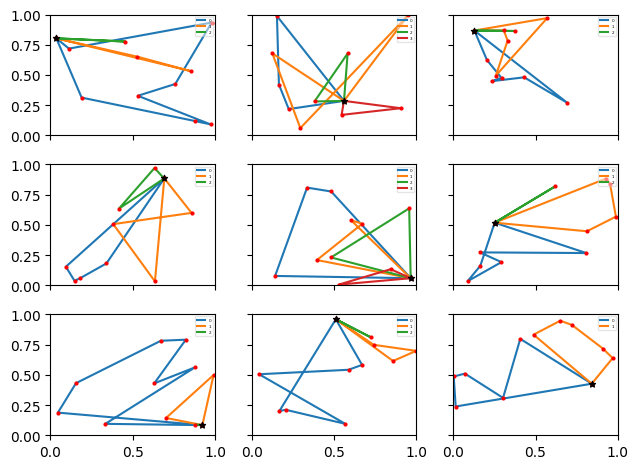

In [11]:
def validate(data_loader, actor, reward_fn, plot_fn=None, save_dir='.',
             num_plot=5):
    """Used to monitor progress on a validation set & optionally plot solution."""

    actor.eval()

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    rewards = []
    for batch_idx, batch in enumerate(data_loader):

        static, dynamic, x0 = batch

        static = static.to(device)
        dynamic = dynamic.to(device)
        x0 = x0.to(device) if len(x0) > 0 else None

        with torch.no_grad():
            tour_indices, _ = actor.forward(static, dynamic, x0)

        reward = reward_fn(static, tour_indices).mean().item()
        rewards.append(reward)

        if plot_fn is not None and batch_idx < num_plot:
            name = 'batch%d_%2.4f.png'%(batch_idx, reward)
            path = os.path.join(save_dir, name)
            plot_fn(static, tour_indices, path)

    actor.train()
    return np.mean(rewards)


for epoch in range(num_epoches):
    actor.train()
    critic.train()

    losses, rewards, critic_rewards = [], [], []
    timer_batch.start()
    timer_epoch.start()
    for batch_idx, batch in enumerate(train_loader):

        static, dynamic, x0 = batch
        static = static.to(device)
        dynamic = dynamic.to(device)
        x0 = x0.to(device) if len(x0) > 0 else None

        # Full forward pass through all features
        tour_indices, tour_logprob = actor(static, dynamic, x0)

        # Sum the log probabilities for each city in the tour
        reward_val = reward_fn(static, tour_indices)

        # Query the critic for an estimate of the reward
        critic_est = critic(static, dynamic).view(-1)

        advantage = (reward_val - critic_est)
        actor_loss = torch.mean(advantage.detach() * tour_logprob.sum(dim=1))
        critic_loss = torch.mean(advantage ** 2)

        advantage = (reward_val - critic_est)
        actor_loss = torch.mean(advantage.detach() * tour_logprob.sum(dim=1))
        critic_loss = torch.mean(advantage ** 2)

        # Backward pass for actor
        actor_optim.zero_grad()
        actor_loss.backward()
        torch.nn.utils.clip_grad_norm_(actor.parameters(), max_grad_norm)
        actor_optim.step()

        # Backward pass for critic
        critic_optim.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(critic.parameters(), max_grad_norm)
        critic_optim.step()

        critic_rewards.append(torch.mean(critic_est.detach()).item())
        rewards.append(torch.mean(reward_val.detach()).item())
        losses.append(torch.mean(actor_loss.detach()).item())

        if (batch_idx + 1) % 100 == 0:
            # Stop the timer at the end of the epoch
            timer_batch.stop()

            mean_loss = np.mean(losses[-100:])
            mean_reward = np.mean(rewards[-100:])

            print('Batch: [%d/%d] | reward: %2.3f | loss: %2.4f | elapsed time: %2.4fs' %
                  (batch_idx, len(train_loader), mean_reward, mean_loss,
                    timer_batch.times[-1]))
            # restart the time
            timer_batch.start()

    mean_loss = np.mean(losses)
    mean_reward = np.mean(rewards)

    # Save the weights
    epoch_dir = os.path.join(checkpoint_dir, '%s' % epoch)
    if not os.path.exists(epoch_dir):
        os.makedirs(epoch_dir)

    save_path = os.path.join(epoch_dir, 'actor.pt')
    torch.save(actor.state_dict(), save_path)

    save_path = os.path.join(epoch_dir, 'critic.pt')
    torch.save(critic.state_dict(), save_path)

    # Save plotting of validation set tours
    valid_dir = os.path.join(save_dir, '%s' % epoch)

    mean_valid = validate(valid_loader, actor, reward_fn, plot_fn,
                          valid_dir, num_plot=5)

    # Save best model parameters
    if mean_valid < best_reward:
        best_reward = mean_valid

        save_path = os.path.join(save_dir, 'actor.pt')
        torch.save(actor.state_dict(), save_path)

        save_path = os.path.join(save_dir, 'critic.pt')
        torch.save(critic.state_dict(), save_path)

    timer_epoch.stop()
    print('Epoch: [%d/%d] | Mean epoch loss/reward: %2.4f, %2.4f, %2.4f | elapsed time: %2.4fs ' \
          '(%2.4fs / 100 batches)\n' % \
          (epoch, num_epoches, mean_loss, mean_reward, mean_valid, timer_epoch.times[-1],
            timer_epoch.avg()))

# **Testing Model**

<ipython-input-3-43a3722dcf87>:171: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(updated_dynamic_feats.data, device = dynamic_feats.device)


Average tour length:  5.443265914916992


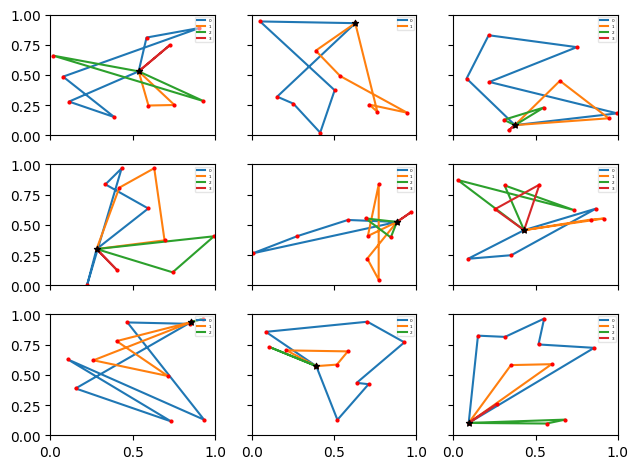

In [13]:
test_data = VRPDataset(valid_size,
                      num_nodes,
                      max_load,
                      MAX_DEMAND,
                      seed + 2)

test_dir = '/content/drive/MyDrive/OR-Tools/VRP/test'
try:
    os.makedirs(test_dir, exist_ok = True)
except OSError as error:
    print("Directory can not be created")
test_loader = DataLoader(test_data, batch_size, False, num_workers=0)
out = validate(test_loader, actor, reward, plot_solution, test_dir, num_plot=5)

print('Average tour length: ', out)